In [1]:
import tensorflow as tf
import keras


print("Tensorflow version:", tf.__version__)
print("Keras version:", keras.__version__)

Tensorflow version: 2.13.0
Keras version: 2.13.1


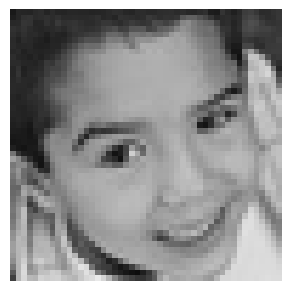

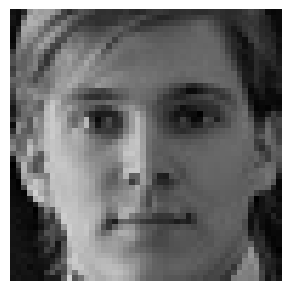

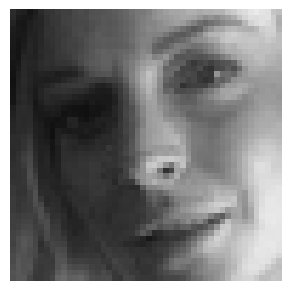

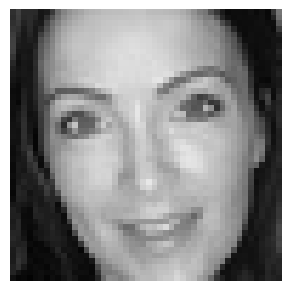

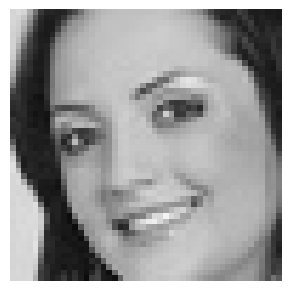

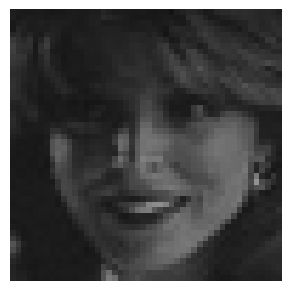

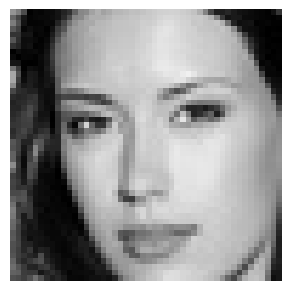

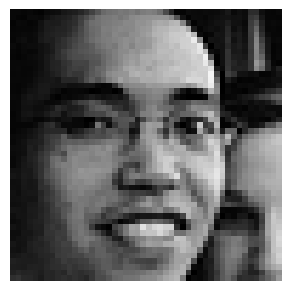

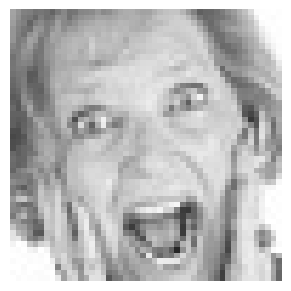

In [2]:
import matplotlib.pyplot as plt
from glob import glob
import random
import cv2


images = glob("../Dataset/train/**/**")
for i in range (9):
    Image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(Image));plt.axis('off')

Preparing Data for training

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("../Dataset/train/",
                                                    target_size= (img_size,img_size),
                                                    color_mode= "grayscale",
                                                    batch_size= batch_size,
                                                    class_mode= "categorical",
                                                    shuffle=True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("../Dataset/test/",
                                                    target_size= (img_size,img_size),
                                                    color_mode= "grayscale",
                                                    batch_size= batch_size,
                                                    class_mode= "categorical",
                                                    shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Defining Model

In [4]:
# class CustomBatchNormalization(tf.keras.layers.Layer):
#     def __init__(self, **kwargs):
#         super(CustomBatchNormalization, self).__init__(**kwargs)
#         self.bn = tf.keras.layers.BatchNormalization()

#     def call(self, inputs, training=False):
#         return self.bn(inputs, training=training)

In [5]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout, Conv2D
from tensorflow.keras.layers import Activation, MaxPooling2D


def Convolution(input_tensor, filter, kernel_size):
    x = Conv2D(filters=filter, kernel_size=kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)

    return x



In [6]:
from tensorflow.keras.layers import Dense, Dropout


def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x



In [7]:
from tensorflow.keras.layers import Flatten, Input
from tensorflow.keras.models import Model

def model_fer(inputs):
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(conv_1 ,64,(5,5))
    conv_3 = Convolution(conv_2,128,(3,3))

    flatten = Flatten()(conv_3)

    dense_1 = Dense_f(flatten,256)

    output = Dense(7,activation= "softmax")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])  # Use 'inputs' instead of 'input'
    
    model.compile(loss = ['categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])

    return model



    

In [8]:
# Define the input shape
input_shape = (48,48,1)

# Create an Input layer
input_layer = Input(shape=input_shape)

# Pass the input layer to your model function
model = model_fer(input_layer)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0     

Initiating the Model

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint


epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor = 'val_accuracy', save_weights_only= True, mode='auto', verbose=1)
callbacks = [checkpoint]

## Training the Model

In [10]:
history = model.fit(
    x = train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_steps//2,
    callbacks=callbacks
)

Epoch 1/5
448/448 [==============================] - ETA: 0s - loss: 1.6755 - accuracy: 0.3586
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 532s 1s/step - loss: 1.6755 - accuracy: 0.3586 - val_loss: 1.5874 - val_accuracy: 0.3708
Epoch 2/5
448/448 [==============================] - ETA: 0s - loss: 1.3892 - accuracy: 0.4676
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 171s 383ms/step - loss: 1.3892 - accuracy: 0.4676 - val_loss: 1.3067 - val_accuracy: 0.4908
Epoch 3/5
448/448 [==============================] - ETA: 0s - loss: 1.2730 - accuracy: 0.5145
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 170s 379ms/step - loss: 1.2730 - accuracy: 0.5145 - val_loss: 1.2902 - val_accuracy: 0.5020
Epoch 4/5
448/448 [==============================] - ETA: 0s - loss: 1.2002 - accuracy: 0.5431
Epoch 4: saving model to model_weights.h5
448/448 [==============================] - 169s 37

Model Evaluation

In [11]:
model.evaluate(validation_generator)

113/113 [==============================] - 10s 86ms/step - loss: 1.1556 - accuracy: 0.5676


[1.1556419134140015, 0.5675675868988037]

Plotting Loss

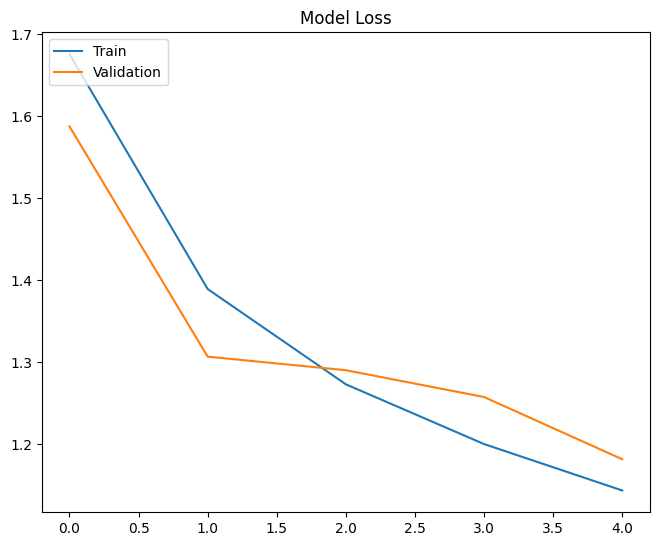

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

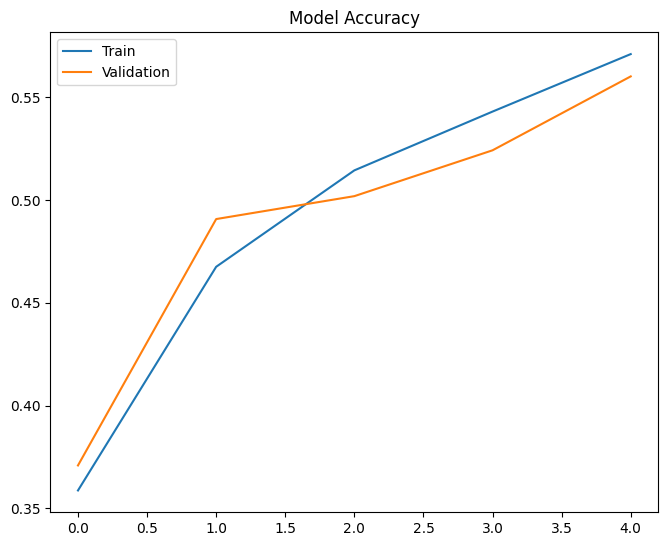

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

Saving Model

In [14]:
model_json = model.to_json()
with open("../Saved model/model_a.json","w") as json_file:
    json_file.write(model_json)